### Maxwell A. Fine 14880725
### Assingment 3: Stastical Methods in Astrophysics

In [82]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps
from uncertainties import ufloat
from scipy.optimize import curve_fit
from lmfit import Model

# Set a seed for reproducibility
random_seed = 50

# Gaia correction term
gaia_corr = 0.029 # mas

assigned_clusters = ['NGC_6611', 'NGC_1817', 'NGC_663', 'Hogg_4']



# Task 1:
First, make stellar density profiles for each of your three clusters. To do this, you first need to create a
new column in your dataframe which contains the radial separation of each star (in arcseconds) from
the centre of its cluster, i.e. � = 3600. '(� − �̅)! + (� − �/)! where � and � are the RA and DE
positions of the star (in degrees) and �̅and �/ are the means of RA and DE for all the stars in the
cluster (i.e. the estimated location of the centre of the cluster). 

Then, use the radial locations of the
stars to make a histogram of stellar number density �∗ vs. radius, that is, the number of stars in a
radial bin, normalized by the area of the radial bin, which will correspond to an annulus on the sky
(use arcsec2 as the units of area). Choose appropriate radial binning and plot the stellar density
profiles (and error bars, if appropriate) for your 3 clusters on separate plots.

### Idea:

### Assumptions:

In [2]:
# Load in Data
# This time I am using _df to indicate it is a pandas df
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars_df = pd.DataFrame(dr3stars[1].data)
stars_df['Name'] = stars_df['Name'].str.strip()
clcounts = stars_df.groupby(['Name']).size().reset_index(name='count') 


# Lets calculate Mean Ra, Dec for the clusters and add it as a Col in the df
stars_df['cluster_mean_RAdeg'] = stars_df.groupby('Name')['RAdeg'].transform('mean')
stars_df['cluster_mean_DEdeg'] = stars_df.groupby('Name')['DEdeg'].transform('mean')

# Lets compute radial dinstance (in deg) of each star from the estimated cluster center (the means) and add it as a Col 
# Double check this works as intended 
stars_df['radial_separation_arcsec'] = 3600 * np.sqrt((stars_df['RAdeg'] - stars_df['cluster_mean_RAdeg'])**2
                                    + (stars_df['DEdeg'] - stars_df['cluster_mean_DEdeg'])**2)  # 3600 is the conversion factor 

# grab assigned star clusters
assigned_clusters_df = stars_df[stars_df['Name'].isin(assigned_clusters)]


Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    edges2=np.zeros(1)  
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

In [4]:
# I feel like we are going to be plotting this a bunch so lets make a function 
def stellar_density_profile_plot(stars_df, cluster_name, model_fitting = False, nbins=50, minibin=20):
    ''''
    Calculate the stellar density profile'''

    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins)  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
    # rebin the data 
    hist, bins = histrebin(mininbin=minibin,counts=hist,edges=bins)

    # Compute bin centers, convert into stellar density 
    bin_centers = (bins[:-1] + bins[1:]) / 2
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2) 
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    # calculate bin widths 
    bin_width = np.diff(bins)

    # Plotting
    fig = plt.figure(figsize=(14, 6), dpi=100)
    # Step plot to look like a histogram
    plt.scatter((bin_centers), stellar_density, alpha=0.4, color='teal',label='Data',zorder=1)
    plt.step(bin_centers, stellar_density, where='mid', color='teal', linewidth=1, alpha=0.4, zorder=1)
    plt.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=bin_width/2, fmt='none', ecolor='teal', capsize=3, alpha=0.4)
    plt.title(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=15)
    plt.xlabel('Distance From Center (arcsec)', size=15)
    plt.ylabel('Sources Per (arcsec$^{-2}$)', size=15)
  #  plt.xscale('log')
   # plt.yscale('log')
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.legend()
    plt.show()  


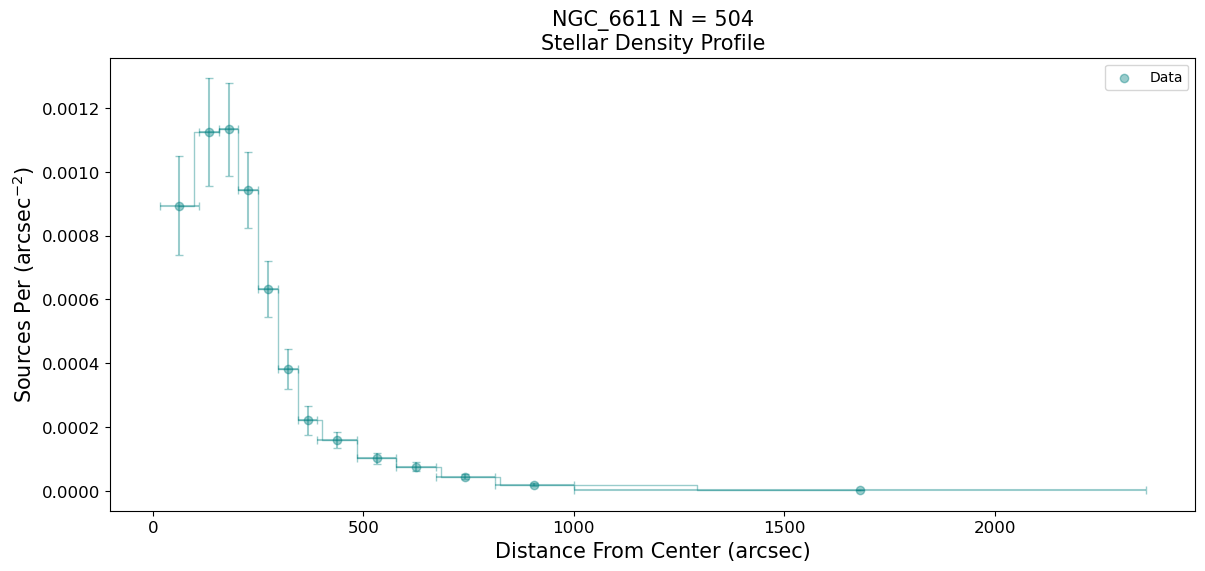

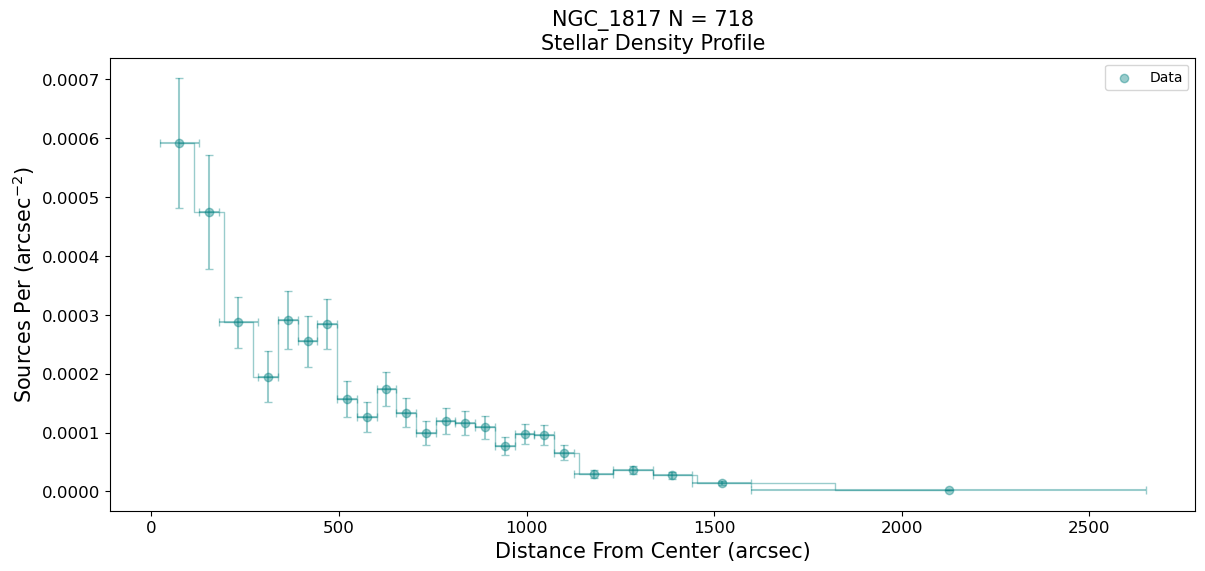

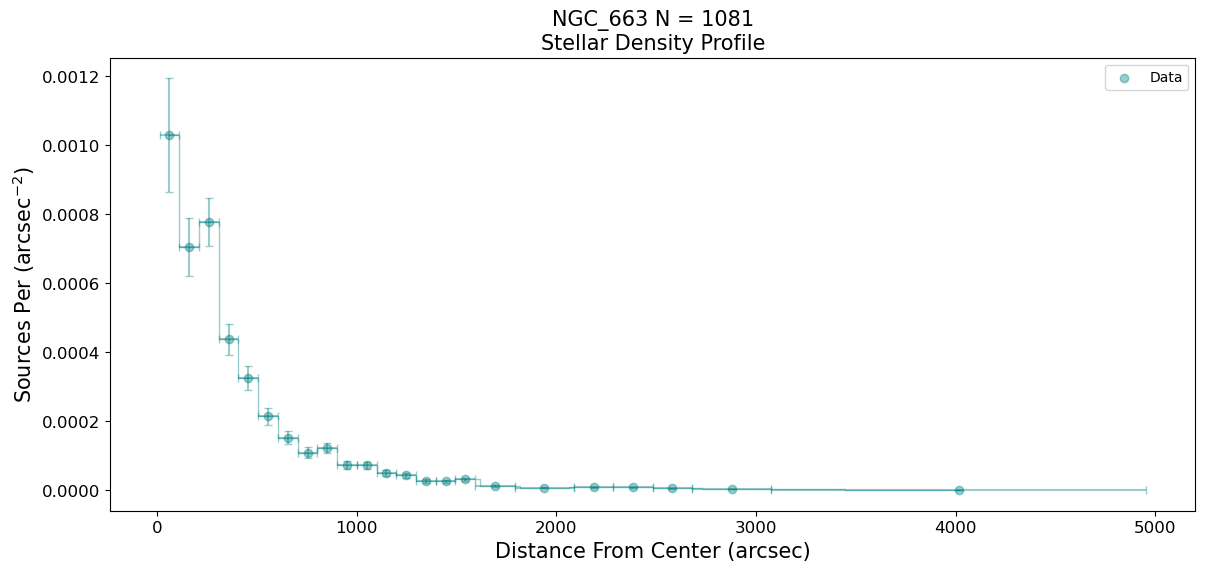

In [5]:
# loop through and plot
for cluster_name in assigned_clusters:
    stellar_density_profile_plot(stars_df, cluster_name)

### 1 Comment

# 2 Task:

Fit the King model to the stellar density profiles of your three clusters to obtain the MLEs for the
parameters and a goodness of fit of the model where appropriate. Plot your data again with the
model fits and residuals or ratios as appropriate.

Obtain 1-sigma confidence intervals on the model parameters, and if the intervals are not closed (i.e. they
include the bounds of the fitted parameters, or zero or infinity), obtain 3-� upper or lower (as
appropriate) limits on the parameters.

Kind Model

$$ \rho(r) = \rho_{0} [\frac{1}{\sqrt{1 + (r/r_{c})^2}} - \frac{1}{\sqrt{1 + (r_t/r_{c})^2}}]^2 + c $$

Where $r< r_c$

where for $r > r_t$, $\rho(r) = c$

Here, �' is a normalization factor, �0 is known as the core radius of the cluster, �/ is the tidal radius
(where the cluster is truncated), and � is a constant which corresponds to the number density of
unassociated foreground/background stars (which may be very small for these data, since the cluster
stars have already been pre-selected based on association in astrometric parameter space). 



* use  lmfit


### Idea:
* We modify our existing plotting function, maybe write a a function to do the fiting and confidence intervals 
* Define king model as its own function


### Assumptions:

In [11]:
#### copy and paste from lesson 

def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel



In [61]:
import numpy as np
import lmfit 

def king_model(x, params):
    r = x
    
    param_values = {}
    for param_name in params.keys():
        param_values[param_name] = params[param_name].value if isinstance(params[param_name], lmfit.Parameter) else params[param_name]

    # Now, you can access individual parameter values using param_values dictionary
    rho_knot = param_values['rho_knot']
    c = param_values['c']
    r_c = param_values['r_c']
    r_t = param_values['r_t']
        
    # Check if all parameters are numeric
    if not all(isinstance(param, (int, float)) for param in [rho_knot, c, r_c, r_t]):
        print('error in function')
        raise ValueError("All parameters must be numeric.")
    
    # Perform calculations
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    
    # Use boolean indexing to set values for r > r_t if rho_king is a NumPy array
    if isinstance(rho_king, np.ndarray):
        print(rho_king)
        rho_king[r > r_t] = c

    else:
        if r > r_t:
            rho_king = c
    
    return rho_king


In [48]:
# get data from stars_df
nbins = 50
source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

hist, bins = np.histogram(source_distance, bins=nbins, range=[0,np.max(source_distance)])  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
    # rebin the data 
hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)


print('min counts', np.min(hist))
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers
annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
#annulus_area = np.pi * np.diff(bins)**2
stellar_density = (hist/ annulus_area)
std_stellar_den = np.sqrt(hist) / annulus_area
bin_width = np.diff(bins)
# For convience 
x_data = bins
y_data = stellar_density
y_data_errors = std_stellar_den
x_data_errors = bin_width/2


min counts 21.0


AttributeError: 'numpy.float64' object has no attribute 'value'

min counts 20.0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 15
    # variables        = 4
    chi-square         = 28.5106129
    reduced chi-square = 2.59187390
    Akaike info crit   = 17.6333930
    Bayesian info crit = 20.4655938
[[Variables]]
    rho_knot:  0.00193744 +/- 2.8063e-04 (14.48%) (init = 1)
    c:         1.9914e-06 +/- 1.0797e-06 (54.22%) (init = 1e-05)
    r_c:       226.909377 +/- 41.1763552 (18.15%) (init = 500)
    r_t:       1512.38280 +/- 293.063555 (19.38%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, r_t)        = -0.7628
    C(r_c, r_t)      = -0.7401
    C(c, r_c)        = +0.4985
    C(rho_knot, r_c) = -0.3207
    C(rho_knot, r_t) = -0.2851
    C(rho_knot, c)   = +0.2491
Minimum Chi-squared = 28.510612852844798 for 11 d.o.f.
The goodness of fit is:  0.002702189642467415
[1.33888112e-03 1.05972530e-03 8.46292620e-04 6.57745661e-04
 5.05586723e-04 3.88002576e-04 2.98

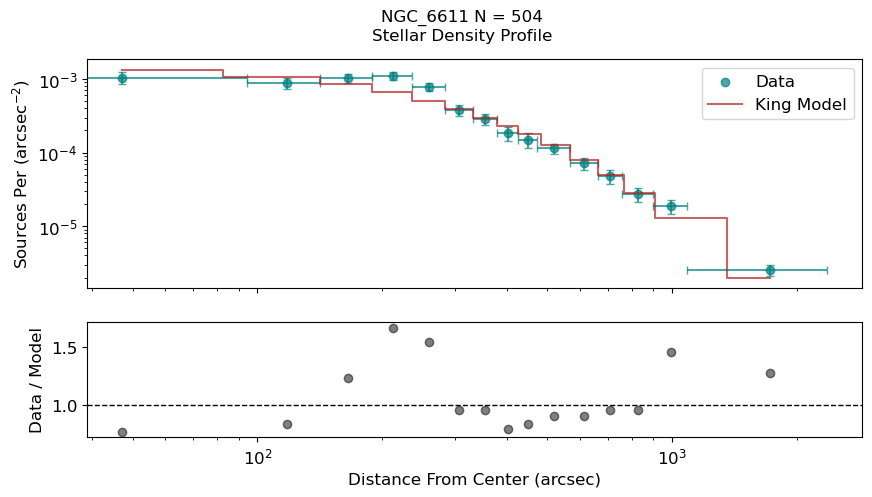

min counts 21.0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 24
    # variables        = 4
    chi-square         = 28.5291535
    reduced chi-square = 1.42645768
    Akaike info crit   = 12.1489439
    Bayesian info crit = 16.8611593
[[Variables]]
    rho_knot:  7.4987e-04 +/- 1.8433e-04 (24.58%) (init = 1)
    c:         3.0200e-07 +/- 2.2466e-06 (743.92%) (init = 1e-05)
    r_c:       806.679603 +/- 164.894494 (20.44%) (init = 500)
    r_t:       2343.82529 +/- 424.324442 (18.10%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_knot, r_t) = -0.9799
    C(c, r_t)        = -0.9593
    C(rho_knot, c)   = +0.9262
    C(r_c, r_t)      = -0.8898
    C(rho_knot, r_c) = +0.8627
    C(c, r_c)        = +0.7895
Minimum Chi-squared = 28.52915350174733 for 20 d.o.f.
The goodness of fit is:  0.09745299459144757
[3.39345749e-04 3.28269042e-04 3.09092536e-04 2.83943144e-04
 2.65048333e-04 2.45254025e-04 2.251

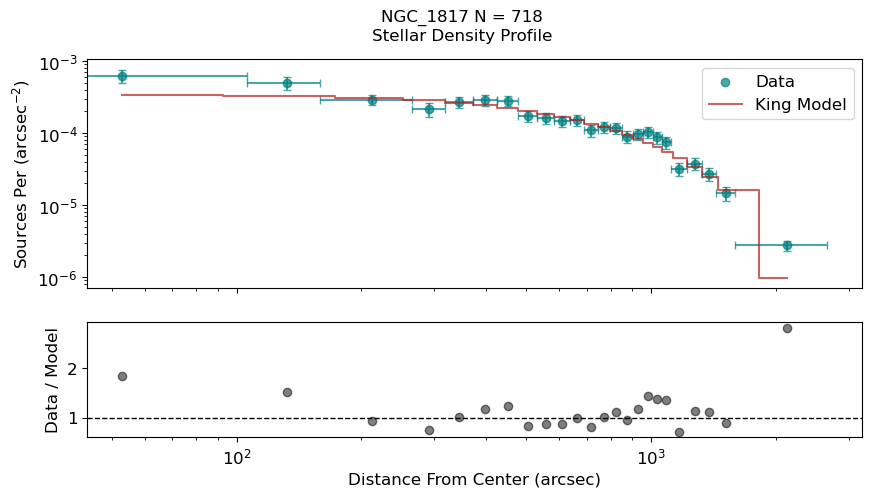

min counts 21.0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 23
    # variables        = 4
    chi-square         = 44.6380631
    reduced chi-square = 2.34937174
    Akaike info crit   = 23.2511324
    Bayesian info crit = 27.7931093
[[Variables]]
    rho_knot:  0.00122741 +/- 1.5147e-04 (12.34%) (init = 1)
    c:         1.9729e-07 +/- 4.0063e-07 (203.07%) (init = 1e-05)
    r_c:       308.817005 +/- 34.7376436 (11.25%) (init = 500)
    r_t:       4825.34090 +/- 826.537790 (17.13%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, r_t)        = -0.9050
    C(rho_knot, r_c) = -0.7793
    C(r_c, r_t)      = -0.6669
    C(c, r_c)        = +0.5407
    C(rho_knot, r_t) = +0.1597
    C(rho_knot, c)   = -0.1019
Minimum Chi-squared = 44.63806313558491 for 19 d.o.f.
The goodness of fit is:  0.0007700326000644705
[1.04701709e-03 8.60541544e-04 6.29827645e-04 4.43837221e-04
 3.13895153e-04 2.26290364e-04 1.6

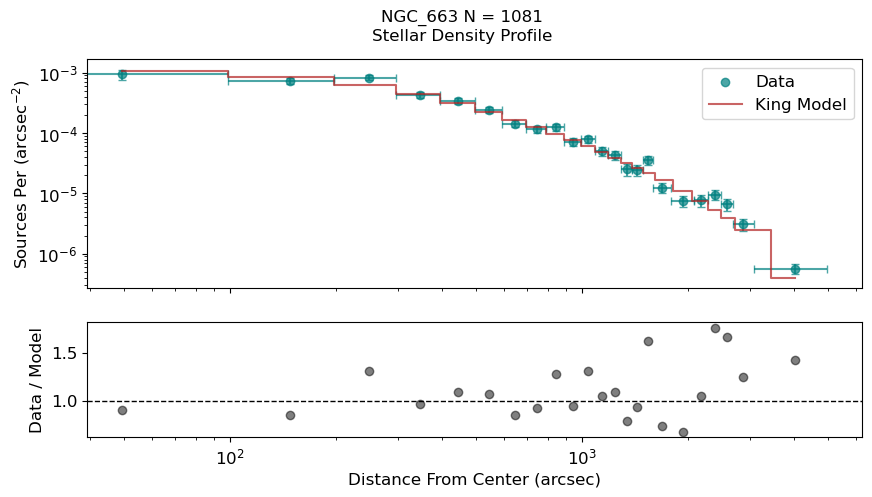

min counts 20.0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10000
    # data points      = 20
    # variables        = 4
    chi-square         = 24.3049748
    reduced chi-square = 1.51906093
    Akaike info crit   = 11.8989756
    Bayesian info crit = 15.8819047
##  Warning: uncertainties could not be estimated:
    c:         at boundary
[[Variables]]
    rho_knot:  0.00125866 (init = 1)
    c:         2.9651e-12 (init = 1e-05)
    r_c:       296.787294 (init = 500)
    r_t:       2355.02805 (init = 1000)
Minimum Chi-squared = 24.30497480434546 for 16 d.o.f.
The goodness of fit is:  0.0830518982130196
[9.36971685e-04 8.16610043e-04 7.09485165e-04 6.00850529e-04
 5.01022077e-04 4.14476413e-04 3.41934789e-04 2.82239516e-04
 2.33545762e-04 1.93938526e-04 1.61696457e-04 1.35372226e-04
 1.13789705e-04 8.83065754e-05 6.90372842e-05 5.43036257e-05
 3.97170406e-05 2.70621856e-05 1.58649386e-05 1.60444112e-06]
[9.36971685e-04 8.16610043e-04 7.09485165e-04 6.0

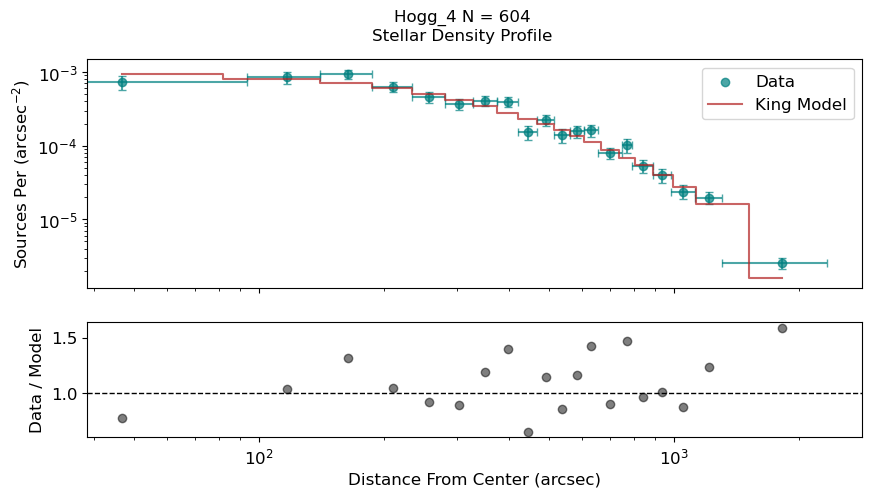

In [87]:
# now all in one cell
from lmfit import Model, Minimizer, Parameters, report_fit

# get data from stars_df

for cluster_name in assigned_clusters:

    nbins = 50
    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins, range=[0,np.max(source_distance)])  # Adjust the number of bins as needed
                                                                                        # Using SQRT of n rule for the moment
        
        # rebin the data 
    hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)


    print('min counts', np.min(hist))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    bin_width = np.diff(bins)
    # For convience 
    x_data = bins
    y_data = stellar_density
    y_data_errors = std_stellar_den
    x_data_errors = bin_width/2


    # all together now
    model = king_model
    output_resid = True

    # set params
    # set params
    param_guess = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}
    params = Parameters()
    params.add_many(('rho_knot', 1), ('c', 1e-5), ('r_c', 500), ('r_t', 1000))

    # Define parameter bounds
    param_bounds = {'rho_knot': (0, np.inf), 'c': (1e-12, 1e-4), 'r_c': (0, np.inf), 'r_t': (0, np.inf)}

    # Create Parameters with bounds
    params = lmfit.Parameters()
    for param_name, param_value in param_guess.items():
        bounds = param_bounds.get(param_name, (-np.inf, np.inf))
        params.add(param_name, value=param_value, min=bounds[0], max=bounds[1])



    xdata = [bins]
    ydata = [stellar_density]
    yerrs = [std_stellar_den]
    set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    report_fit(result)
    print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))


    #### plot stuff
    # Extracting the best-fit parameters
    best_fit_params = result.params.valuesdict()

    # Generate x values for the model plot

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5), dpi=100, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    x_data = bin_centers
    # Plot data and fit in the first subplot
    ax1.scatter(x_data, y_data, label='Data', color='teal',alpha=0.7)
    ax1.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=x_data_errors, fmt='none', ecolor='teal', capsize=3, alpha=0.7)
    #ax1.step(bin_centers, stellar_density, where='mid', color='teal', linewidth=1, alpha=0.7, zorder=1)
    #x_model = np.linspace(min(bin_centers), max(bin_centers), 50)
    x_model = x_data
    ax1.step(x_model, king_model(x_model, best_fit_params), label='King Model', where='mid', linewidth=1.5, color='firebrick',alpha=0.7,)

    ax1.set_ylabel('Sources Per (arcsec$^{-2}$)', size=12)
    ax1.tick_params(axis='both', which='both', labelsize=12)
    ax1.legend(fontsize=12)
    ax1.set_yscale('log')
    ax1.set_xscale('log')

    # Plot residuals in the second subplot

    residuals = y_data - king_model(x_data, best_fit_params)

    # Data ratio 
    #ax2.scatter(x_data, result.best_fit/ y_data, label='Residuals', color='k', alpha=0.5)
    ax2.scatter(x_data, y_data / king_model(x_data, best_fit_params), label='Residuals', color='k', alpha=0.5)
    ax2.axhline(1, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Distance From Center (arcsec)', size=12)
    ax2.set_ylabel('Data / Model', size=12)
    ax2.tick_params(axis='both', which='both', labelsize=12)

    # ax2.set_yscale('log')

    plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
    plt.savefig(cluster_name, bbox_inches='tight')
    plt.show()

### old cells below

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 243
    # data points      = 20
    # variables        = 4
    chi-square         = 23.5922565
    reduced chi-square = 1.47451603
    Akaike info crit   = 11.3037254
    Bayesian info crit = 15.2866545
[[Variables]]
    rho_knot:  0.00123251 +/- 1.4090e-04 (11.43%) (init = 1)
    c:        -9.3363e-07 +/- 3.2359e-06 (346.59%) (init = 1e-05)
    r_c:       298.225809 +/- 46.5038850 (15.59%) (init = 500)
    r_t:       2470.80285 +/- 754.460630 (30.54%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, r_t)        = -0.9775
    C(r_c, r_t)      = -0.8159
    C(c, r_c)        = +0.7413
    C(rho_knot, c)   = +0.4199
    C(rho_knot, r_t) = -0.3860
    C(rho_knot, r_c) = -0.1452
Minimum Chi-squared = 23.59225649468153 for 16 d.o.f.
The goodness of fit is:  0.09879602854867904
[9.27912903e-04 8.10273167e-04 7.05304746e-04 5.98585457e-04
 5.00257549e-04 4.14791810e-04 3.42978202e-04 2.837

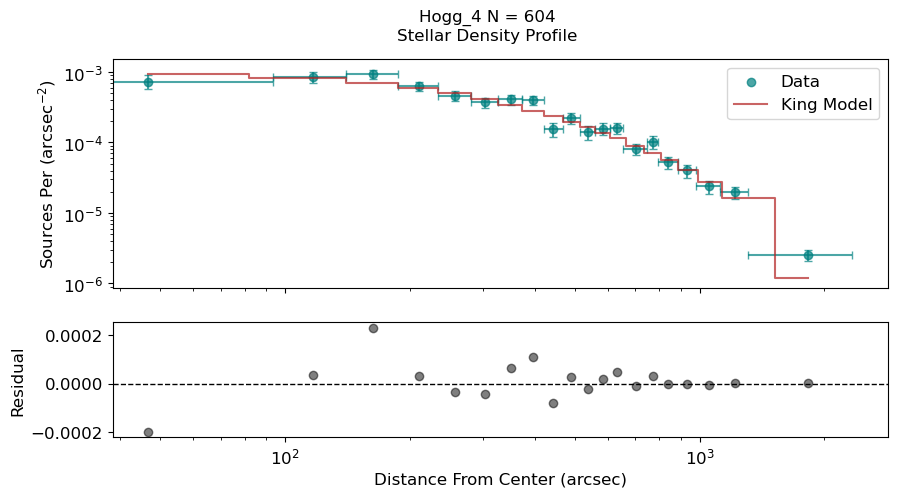

In [88]:
from lmfit import Model, Minimizer, Parameters, report_fit

# all together now
model = king_model
output_resid = True

# set params
# set params
param_guess = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}
params = Parameters()
params.add_many(('rho_knot', 1), ('c', 1e-5), ('r_c', 500), ('r_t', 1000))


xdata = [bins]
ydata = [stellar_density]
yerrs = [std_stellar_den]
set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result = set_function.minimize(method = 'leastsq')
report_fit(result)
print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))


#### plot stuff
# Extracting the best-fit parameters
best_fit_params = result.params.valuesdict()

# Generate x values for the model plot





fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,5), dpi=100, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

x_data = bin_centers
# Plot data and fit in the first subplot
ax1.scatter(x_data, y_data, label='Data', color='teal',alpha=0.7)
ax1.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=x_data_errors, fmt='none', ecolor='teal', capsize=3, alpha=0.7)
#ax1.step(bin_centers, stellar_density, where='mid', color='teal', linewidth=1, alpha=0.7, zorder=1)
#x_model = np.linspace(min(bin_centers), max(bin_centers), 50)
x_model = x_data
ax1.step(x_model, king_model(x_model, best_fit_params), label='King Model', where='mid', linewidth=1.5, color='firebrick',alpha=0.7,)

ax1.set_ylabel('Sources Per (arcsec$^{-2}$)', size=12)
ax1.tick_params(axis='both', which='both', labelsize=12)
ax1.legend(fontsize=12)
ax1.set_yscale('log')
ax1.set_xscale('log')

# Plot residuals in the second subplot

residuals = y_data - king_model(x_data, best_fit_params)

# Data ratio 
#ax2.scatter(x_data, result.best_fit/ y_data, label='Residuals', color='k', alpha=0.5)
ax2.scatter(x_data, residuals, label='Residuals', color='k', alpha=0.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Distance From Center (arcsec)', size=12)
ax2.set_ylabel('Residual', size=12)
ax2.tick_params(axis='both', which='both', labelsize=12)

# ax2.set_yscale('log')

plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
plt.savefig(cluster_name, bbox_inches='tight')
plt.show()

In [ ]:
# all together now
model = pl_model
output_resid = True
xdata = [edges2]
ydata = [cdens]
yerrs = [cdens_err]
set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result = set_function.minimize(method = 'leastsq')
report_fit(result)
print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))

# old cells

In [2]:
# Your King model
def king_model(r, rho_knot, c, r_c, r_t):
    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    rho_king[r > r_t] = c  # for r > r_t, set rho_king = c
    return rho_king



In [99]:
def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
    return ymod




def model_bin(xbins, model, params):
    """General function for integrating the input model over bins defined by contiguous bin edges, xbins."""
    ymod = np.zeros(len(xbins)-1)
    for i in range(len(xbins)-1):
        ymod[i], _ = quad(lambda x: model(x, *params.values()), xbins[i], xbins[i+1])
        ymod[i] /= (xbins[i+1] - xbins[i])
    return ymod


def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

In [100]:
# get data from stars_df
nbins = 50
source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

hist, bins = np.histogram(source_distance, bins=nbins, range=[0,np.max(source_distance)])  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
    # rebin the data 
hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)


print('min counts', np.min(hist))
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers
annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
#annulus_area = np.pi * np.diff(bins)**2
stellar_density = (hist/ annulus_area)
std_stellar_den = np.sqrt(hist) / annulus_area
bin_width = np.diff(bins)
# For convience 
x_data = bin_centers
y_data = stellar_density
y_data_errors = std_stellar_den
x_data_errors = bin_width/2



min counts 21.0


In [101]:
from lmfit import Model, Minimizer

In [102]:
def model_bin(xbins, model, params):
    """General function for integrating the input model over bins defined by contiguous bin edges, xbins."""
    ymod = np.zeros(len(xbins) - 1)
    for i in range(len(xbins) - 1):
        # Use model.eval to evaluate the model at the specified x value
        ymod[i], _ = quad(lambda x: model.eval(params, x=x), xbins[i], xbins[i + 1])
        ymod[i] /= (xbins[i + 1] - xbins[i])
    return ymod





In [97]:
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers
annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
#annulus_area = np.pi * np.diff(bins)**2
stellar_density = (hist/ annulus_area)
std_stellar_den = np.sqrt(hist) / annulus_area
bin_width = np.diff(bins)
# For convience 
x_data = bin_centers
y_data = stellar_density
y_data_errors = std_stellar_den
x_data_errors = bin_width/2

In [103]:
def king_model(r, params):
    v = params.valuesdict()
    rho_knot = v['rho_knot']
    c = v['c']
    r_c = v['r_c']
    r_t = v['r_t']

    frac1 = 1 / np.sqrt(1 + (r / r_c)**2)
    frac2 = 1 / np.sqrt(1 + (r_t / r_c)**2)
    rho_king = rho_knot * (frac1 - frac2)**2 + c
    rho_king[r > r_t] = c  # for r > r_t, set rho_king = c
    return rho_king

In [108]:
model = king_model
output_resid = True
xdata = [bins]
ydata = y_data
yerrs = y_data_errors
set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result = set_function.minimize(method = 'leastsq')
report_fit(result)
print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))

AttributeError: 'MinimizerResult' object has no attribute 'params'

In [107]:

model = king_model
params = {'rho_knot': 1, 'c': 1e-5, 'r_c': 500, 'r_t': 1000}

   # param_bounds = {'c': (1e-12, 1e-4), 'r_c': (0, np.inf), 'r_t': (0, np.inf), 'rho_knot': (0, np.inf)}


output_resid = True
xdata = [bins]
#ydata = [cdens]
#yerrs = [cdens_err]

yerrs = y_data_errors
ydata = y_data



set_function = Minimizer(lmf_lsq_binresid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result = set_function.minimize(method = 'leastsq')
report_fit(result)
print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))

AttributeError: 'MinimizerResult' object has no attribute 'params'

In [3]:
def fit_and_plot(stars_df,cluster_name, initial_params, model_func = king_model, nbins=50,
                 param_bounds=None, figsize=(10, 5), minibin=20):
    # Create an lmfit model from the function
    model = Model(model_func)

    # Set initial parameter values
    params = model.make_params(**initial_params)


    # get data from stars_df
    source_distance = stars_df[stars_df['Name'] == cluster_name]['radial_separation_arcsec'] # arcsec

    hist, bins = np.histogram(source_distance, bins=nbins, range=[0,np.max(source_distance)])  # Adjust the number of bins as needed
                                                                                      # Using SQRT of n rule for the moment
    
    # rebin the data 
    hist, bins = histrebin(mininbin=20,counts=hist,edges=bins)


    print('min counts', np.min(hist))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2)  # this is wrong?
    #annulus_area = np.pi * np.diff(bins)**2
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    bin_width = np.diff(bins)
    # For convience 
    x_data = bin_centers
    y_data = stellar_density
    y_data_errors = std_stellar_den
    x_data_errors = bin_width/2

    print('len y_data', len(y_data), 'len y_data_errors', len(y_data_errors))
    print(y_data)
    print(y_data_errors)

    # now we do the redine of y_data
    y_data = model_bin(bins, model_func, params)
    print('what is new y_data', np.shape(y_data))
    print(y_data)


    # Set parameter bounds if provided
    if param_bounds:
        for param, bounds in param_bounds.items():
            params[param].min, params[param].max = bounds

    # Fit the model to the data
    # params=params
    
    #result = model.fit(model_bin(x_data, model_func, params), params=params, x=x_data, weights=1.0 / y_data_errors)

    result = model.fit(y_data, params=params, r=x_data, weights=1.0 / y_data_errors,) # fit_kws={"absolute_sigma": True})

    # Print the fit results 
    result.params.pretty_print()
    print(f"Reduced Chi-square: {result.redchi}")
    print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sps.chi2.sf(result.chisqr,df=result.nfree))


    # Check if the fit has converged
    if not result.success:
        print("Fit did not converge!")

    # Confidence intervals and parameter limits
    conf_interval = result.conf_interval()
    
    # Collect 1-sigma intervals
    param_intervals = {}
    for param in result.params:
        conf_int = conf_interval[param]
        param_intervals[param] = (result.params[param].value - conf_int[1][1], result.params[param].value + conf_int[0][1])

        # Adjust intervals if not closed
        if param_intervals[param][0] <= result.params[param].min or np.isinf(param_intervals[param][0]) or param_intervals[param][0] < 0:
            # Use 3-sigma lower limit
            param_intervals[param] = (result.params[param].value - 3 * conf_int[1][1], result.params[param].value)

        if param_intervals[param][1] >= result.params[param].max or np.isinf(param_intervals[param][1]):
            # Use 3-sigma upper limit
            param_intervals[param] = (result.params[param].value, result.params[param].value + 3 * conf_int[0][1])

    print("Parameter Intervals:")
    for param, interval in param_intervals.items():
        print(f"{param}: {interval}")


    # Plotting data and fit, and residuals in two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=figsize, dpi=100, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Plot data and fit in the first subplot
    ax1.scatter(x_data, y_data, label='Data', color='teal',alpha=0.7)
    ax1.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, xerr=x_data_errors, fmt='none', ecolor='teal', capsize=3, alpha=0.7)
    #ax1.step(bin_centers, stellar_density, where='mid', color='teal', linewidth=1, alpha=0.7, zorder=1)
    ax1.step(x_data, result.best_fit, label='King Model', where='mid', linewidth=1.5, color='firebrick',alpha=0.7,)

    ax1.set_ylabel('Sources Per (arcsec$^{-2}$)', size=12)
    ax1.tick_params(axis='both', which='both', labelsize=12)
    ax1.legend(fontsize=12)
    ax1.set_yscale('log')
    ax1.set_xscale('log')

    # Plot residuals in the second subplot
    # Data ratio 
    ax2.scatter(x_data, result.best_fit/ y_data, label='Residuals', color='k', alpha=0.5)
    ax2.scatter(x_data, result.residual, label='Residuals', color='k', alpha=0.5)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Distance From Center (arcsec)', size=12)
    ax2.set_ylabel('Residual', size=12)
    ax2.tick_params(axis='both', which='both', labelsize=12)

   # ax2.set_yscale('log')

    plt.suptitle(cluster_name + ' N = '+ str(len(source_distance)) + '\nStellar Density Profile', size=12)
    plt.savefig(cluster_name, bbox_inches='tight')
    plt.show()
    
    return result, conf_interval

In [4]:
#cluster_names = ['Berkeley_17', 'IC_1396', 'NGC_2194']
cluster_names = assigned_clusters
#cluster_names = ['Hogg_4']
for cluster_name in cluster_names:

    initial_params = {'rho_knot': 1, 'c': 1, 'r_c': 500, 'r_t': 1000}
    param_bounds = {'c': (1e-12, 1e-4), 'r_c': (0, 1e4), 'r_t': (initial_params['r_c'], 1e10), 'rho_knot': (0, 2e6)}
   # param_bounds = {'c': (1e-12, 1e-4), 'r_c': (0, np.inf), 'r_t': (0, np.inf), 'rho_knot': (0, np.inf)}

    result, conf_interval = fit_and_plot(stars_df,cluster_name, initial_params, model_func = king_model, nbins=50,
                    param_bounds=param_bounds, figsize=(10, 5))

NameError: name 'stars_df' is not defined

In [63]:
from scipy.integrate import quad
